In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
# Text preprocessing function
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuations except spaces
    text = text.lower()
    return text    

def preprocess_text(text):
    # Lowercasing
    text = clean(text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Read dataset & Preprocess text
df_train = pd.read_csv('dataset-emotion/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('dataset-emotion/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('dataset-emotion/test.txt', names=['Text', 'Emotion'], sep=';')

In [24]:
# Preprocess text
df_train['Text_clean'] = df_train['Text'].apply(preprocess_text)
df_val['Text_clean'] = df_val['Text'].apply(preprocess_text)
df_test['Text_clean'] = df_test['Text'].apply(preprocess_text)

In [37]:
df_train[['Emotion', 'Text_clean']].head(10)

,Emotion,Text_clean
0,sadness,didnt feel humiliated
1,sadness,go feeling hopeless damned hopeful around some...
2,anger,im grabbing minute post feel greedy wrong
3,love,ever feeling nostalgic fireplace know still pr...
4,anger,feeling grouchy
5,sadness,ive feeling little burdened lately wasnt sure
6,surprise,ive taking milligram time recommended amount i...
7,fear,feel confused life teenager jaded year old man
8,joy,petronas year feel petronas performed well mad...
9,love,feel romantic


In [39]:
df_train[['Emotion', 'Text_clean']].tail(10)

,Emotion,Text_clean
15990,joy,feel really glad dont look like celebrity beau...
15991,sadness,wanted perhaps convey feeling matter instead t...
15992,anger,moved away said something made feel violent so...
15993,joy,day feel like braeden calvin happy successful day
15994,love,feel sympathetic empathetic towards
15995,sadness,brief time beanbag said anna feel like beaten
15996,sadness,turning feel pathetic still waiting table subb...
15997,joy,feel strong good overall
15998,anger,feel like rude comment im glad
15999,sadness,know lot feel stupid portray


In [40]:
df_train[['Emotion', 'Text_clean']].sample(n=10, random_state=42)

,Emotion,Text_clean
8756,sadness,ive made week feel beaten
4660,joy,feel strategy worthwhile
6095,sadness,feel worthless weak say want find
304,joy,feel clever nov
8241,sadness,im moved ive feeling kind gloomy
9577,sadness,allowed feel really shitty feeling running end...
1035,fear,feel confused
9976,sadness,feel like crappy mummy stuck day really cant f...
7872,love,feel like liked hair much better using sulfate...
8341,fear,feel self pressured expectation keep date fami...


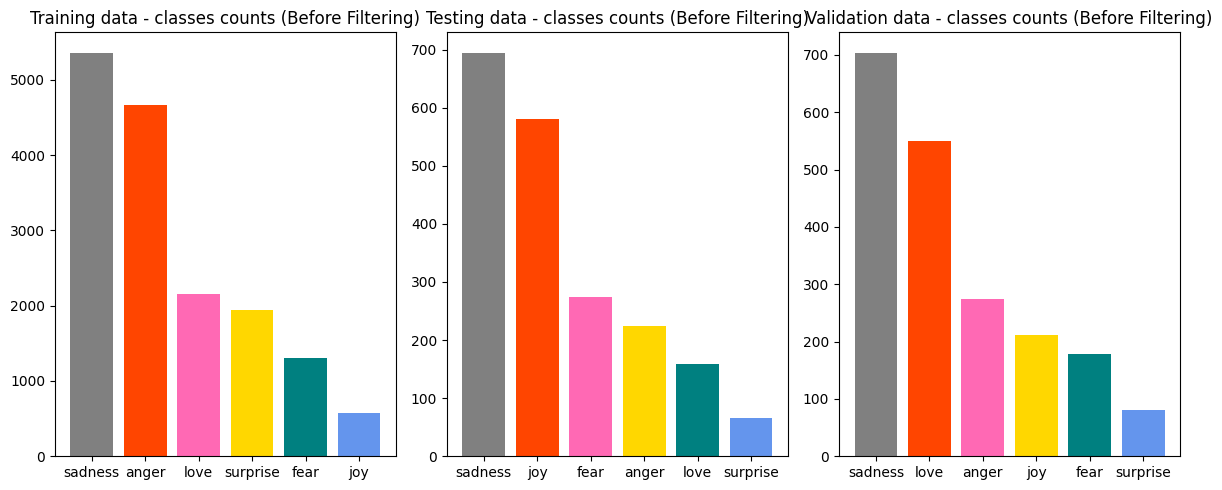

In [25]:
# Visualize classes counts before filtering out 'surprise' and 'love' classes
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.bar(df_train['Emotion'].unique(), height=df_train['Emotion'].value_counts(), color=colors)
plt.title("Training data - classes counts (Before Filtering)")

plt.subplot(1, 3, 2)
plt.bar(df_test['Emotion'].unique(), height=df_test['Emotion'].value_counts(), color=colors)
plt.title("Testing data - classes counts (Before Filtering)")

plt.subplot(1, 3, 3)
plt.bar(df_val['Emotion'].unique(), height=df_val['Emotion'].value_counts(), color=colors)
plt.title("Validation data - classes counts (Before Filtering)")

plt.tight_layout()
plt.show()

In [26]:
# Filter out 'surprise' and 'love' classes
df_train_filtered = df_train[(df_train['Emotion'] != 'surprise') & (df_train['Emotion'] != 'love')]
df_test_filtered = df_test[(df_test['Emotion'] != 'surprise') & (df_test['Emotion'] != 'love')]
df_val_filtered = df_val[(df_val['Emotion'] != 'surprise') & (df_val['Emotion'] != 'love')]

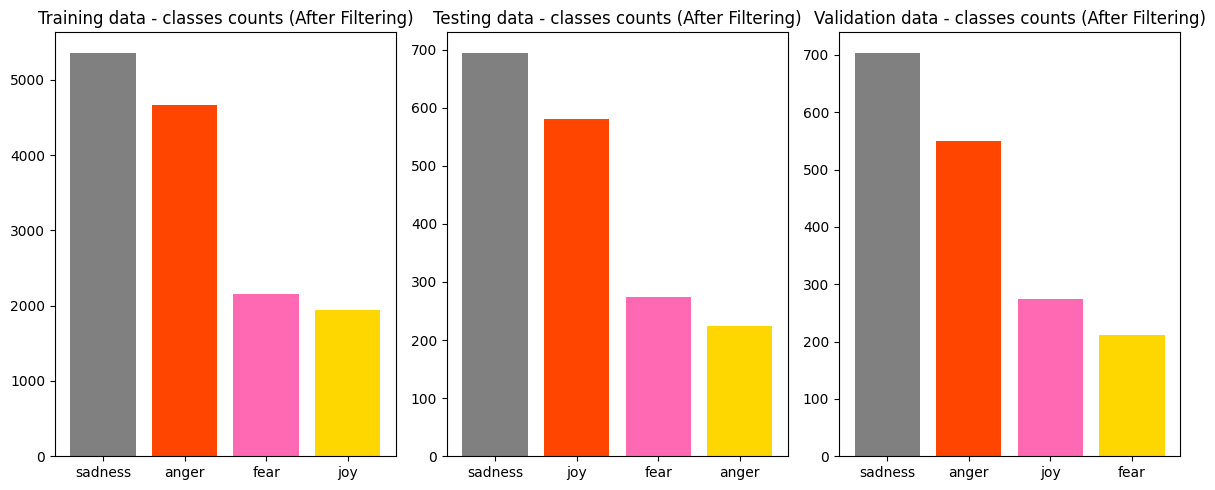

In [27]:
# Visualize classes counts after filtering out 'surprise' and 'love' classes
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.bar(df_train_filtered['Emotion'].unique(), height=df_train_filtered['Emotion'].value_counts(), color=colors)
plt.title("Training data - classes counts (After Filtering)")

plt.subplot(1, 3, 2)
plt.bar(df_test_filtered['Emotion'].unique(), height=df_test_filtered['Emotion'].value_counts(), color=colors)
plt.title("Testing data - classes counts (After Filtering)")

plt.subplot(1, 3, 3)
plt.bar(df_val_filtered['Emotion'].unique(), height=df_val_filtered['Emotion'].value_counts(), color=colors)
plt.title("Validation data - classes counts (After Filtering)")

plt.tight_layout()
plt.show()

In [28]:
# # Visualize classes counts
# colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

# plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
# plt.title("Training data - classes counts")
# plt.show()

# plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
# plt.title("Testing data - classes counts")
# plt.show()

# plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
# plt.title("Validation data - classes counts")
# plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [6]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [7]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 13256


In [8]:
# Read GloVE embeddings

path_to_glove_file = 'glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

In [9]:
# Read word vectors
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [10]:
# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12314 words (941 misses)


In [11]:
# Build neural network architecture
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))  # Change to 4 classes

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2651200   
                                                                 
 lstm (LSTM)                 (None, 256, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 2,869,316
Trainable params: 218,116
Non-trainable params: 2,651,200
_________________________________________________________________


In [12]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=128,
                    epochs=10,
                    callbacks=[callback]
                   )

model.evaluate(X_val, y_val, verbose=1)

Epoch 1/10
111/111 [==============================] - 653s 6s/step - loss: 0.6624 - accuracy: 0.7413 - val_loss: 0.2599 - val_accuracy: 0.9189
Epoch 2/10
111/111 [==============================] - 683s 6s/step - loss: 0.2218 - accuracy: 0.9204 - val_loss: 0.1331 - val_accuracy: 0.9510
Epoch 3/10
111/111 [==============================] - 733s 7s/step - loss: 0.1264 - accuracy: 0.9513 - val_loss: 0.1000 - val_accuracy: 0.9589
Epoch 4/10
111/111 [==============================] - 803s 7s/step - loss: 0.0869 - accuracy: 0.9638 - val_loss: 0.1140 - val_accuracy: 0.9577
Epoch 5/10
111/111 [==============================] - 821s 7s/step - loss: 0.0659 - accuracy: 0.9728 - val_loss: 0.0950 - val_accuracy: 0.9589
Epoch 6/10
111/111 [==============================] - 856s 8s/step - loss: 0.0580 - accuracy: 0.9739 - val_loss: 0.0886 - val_accuracy: 0.9651
Epoch 7/10
111/111 [==============================] - 854s 8s/step - loss: 0.0465 - accuracy: 0.9800 - val_loss: 0.0836 - val_accuracy: 0.9668

[0.09168987721204758, 0.9638139009475708]

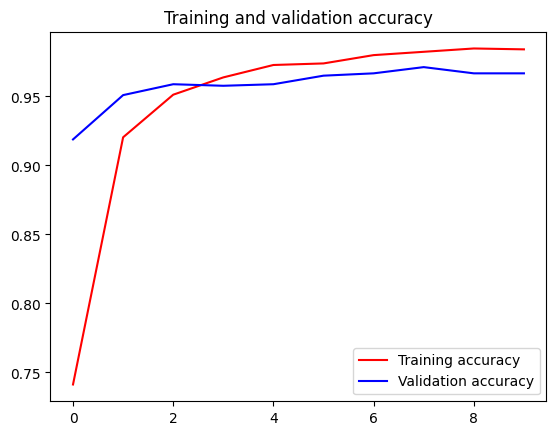

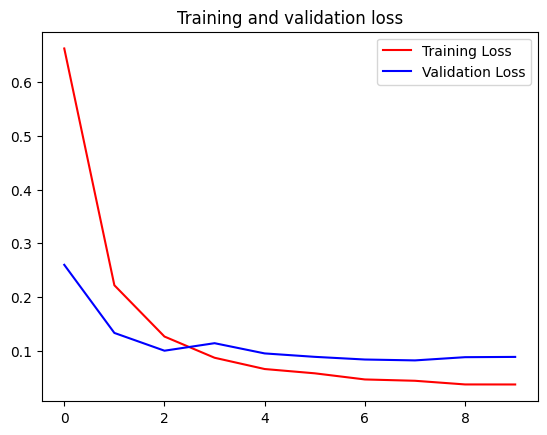

In [16]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    preprocessed_sentence = preprocess_text(sentence)  # Preprocess the sentence
    tokenized_sentence = tokenizer.texts_to_sequences([preprocessed_sentence])  # Tokenize the preprocessed sentence
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=256, truncating='pre')  # Pad the tokenized sentence
    result = le.inverse_transform(np.argmax(model.predict(padded_sentence), axis=-1))[0]  # Predict emotion
    proba =  np.max(model.predict(padded_sentence))  # Get probability
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 0s 78ms/step
joy : 0.9989527463912964


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 78ms/step
anger : 0.9175673127174377


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 70ms/step
anger : 0.552254319190979


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 70ms/step
joy : 0.7899337410926819




In [15]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('emotion-detection-2.h5')

In [2]:
import re
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

with open('labelEncoder.pickle', 'rb') as f:
    le = pickle.load(f)

model = load_model('emotion-detection-2.h5')

def clean(text):
    str_punc = string.punctuation.replace(',', '').replace("'",'')
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuations except spaces
    text = text.lower()
    return text    

def preprocess_text(text):
    text = clean(text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def predict_emotion(sentence):
    sentence = preprocess_text(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    return result, proba

sentence = input("Enter a sentence: ")
emotion, probability = predict_emotion(sentence)
print(f'Predicted Emotion: {emotion}, Probability: {probability}')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 [==============================] - 0s 98ms/step
Predicted Emotion: joy, Probability: 0.8479398488998413


In [3]:
import tkinter as tk
from tkinter import messagebox
import re
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
import pickle

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

with open('labelEncoder.pickle', 'rb') as f:
    le = pickle.load(f)

model = load_model('emotion-detection-2.h5')

def clean(text):
    str_punc = string.punctuation.replace(',', '').replace("'",'')
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower()
    return text    

def preprocess_text(text):
    text = clean(text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def predict_emotion(sentence):
    sentence = preprocess_text(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    predictions = model.predict(sentence)[0]
    result_index = np.argmax(predictions)
    result_label = le.inverse_transform([result_index])[0]
    confidence_rate = predictions[result_index]
    return result_label, confidence_rate, predictions

def predict():
    sentence = entry.get()
    if sentence.strip() == "":
        messagebox.showwarning("Warning", "Please enter a sentence.")
    else:
        emotion, confidence, predictions = predict_emotion(sentence)
        other_emotions = [f"{label}: {round(confidence * 100, 2)}%" for label, confidence in zip(le.classes_, predictions)]
        other_emotions = "\n".join(other_emotions)
        messagebox.showinfo("Prediction Result", f"Predicted Emotion: {emotion}\nConfidence Rate: {round(confidence * 100, 2)}%\n\nOther Emotions:\n{other_emotions}")

root = tk.Tk()
root.title("Emotion Prediction")

label = tk.Label(root, text="Enter a sentence:")
label.pack()
entry = tk.Entry(root, width=50)
entry.pack()

button = tk.Button(root, text="Predict", command=predict)
button.pack()

# Run the GUI
root.mainloop()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 [==============================] - 0s 72ms/step
